### 形態素解析した結果と極性辞書を元に、感情の強いツイートのみを出力

In [1]:
import pandas

In [2]:
df = pandas.read_csv("output/deresute_mecab.tsv", sep="\t", engine="python")

In [3]:
df.head()

,created_time,descripton,favorite_count,retweet_count,tweet_text,description_mecab,tweet_text_mecab
0,2018-05-09 05:23:54,ガンダム勢 TF SDガンダム 四条貴音 水瀬伊織 北上麗花 桜守歌織 鷺沢文香 高峯のあ ...,1,2.0,前回の総選挙とまとめてみた1票でもいいので私の担当をよろしくお願いします#第七回シンデレラガ...,"[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('ガンダム', '名詞...","[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('前回', '名詞,一..."
1,2018-05-09 05:23:43,ディズニーランドに住みたい。成人済。,0,0.0,【アイドルマスター シンデレラガールズ スターライトステージ】でシンデレラガール総選挙開催中...,"[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('ディズニーランド',...","[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('【', '記号,括弧..."
2,2018-05-09 05:23:43,アニメ/ゲーム/ロボット/仮面ライダー/水樹奈々/雪村杏/ミリタリー/世界史/戦国/自動車/...,0,0.0,【アイドルマスター シンデレラガールズ スターライトステージ】でシンデレラガール総選挙開催中...,"[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('アニメ', '名詞,...","[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('【', '記号,括弧..."
3,2018-05-09 05:23:33,グッズ取引用アカウント。好きなキャラも交換譲渡に出すことがあります。本垢有り。成人済：大阪,0,0.0,【譲渡】シンデレラ モバマス デレマス デレステ しんげき おまんじゅう （譲）★神崎蘭子1...,"[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('グッズ', '名詞,...","[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('【', '記号,括弧..."
4,2018-05-09 05:23:23,「アイドルマスター シンデレラガールズ スターライトステージ」専門リセマラアカウント販売を行...,0,0.0,◆デレステ リセマラ垢 販売多田李衣菜 SSR ＜ヒート＆ビート＞アマゾンギフト or We...,"[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('「', '記号,括弧...","[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('◆', '記号,一般..."


### 極性辞書の読み込み、pickleへ保存
今回はこれを使う
http://www.lr.pi.titech.ac.jp/~takamura/pndic_ja.html


以下、ページから引用


```
日本語および英語の単語とその感情極性の対応表を、 研究目的の利用に限り公開します。 感情極性とは、その語が一般的に良い印象を持つか（positive） 悪い印象を持つか（negative）を表した二値属性です。 例えば、「良い」、「美しい」などはpositiveな極性、 「悪い」、「汚い」などはnegativeな極性を持ちます。

感情極性値は、語彙ネットワークを利用して自動的に計算されたものです。 もともと二値属性ですが、-1から+1の実数値を割り当てました。 -1に近いほどnegative、+1に近いほどpositiveと考えられます。 リソースとして、日本語は「岩波国語辞書（岩波書店）」を、 英語はWordNet-1.7.1を使わせていただきました。 
```

In [4]:
ls resources/

pn.csv.m3.120408.trim  pn_ja.dic.txt.utf-8
pn_ja.dic.txt          wago.121808.pn.txt


In [22]:
sentiment_word_dic = {}

file = open("resources/pn_ja.dic.txt.utf-8", mode="r", encoding="utf-8")
with file:
    for l in file:
        surface, yomi, pos, value = l.strip().split(":")
        sentiment_word_dic[surface] = float(value)

In [24]:
import joblib

ModuleNotFoundError: No module named 'joblib'

In [25]:
!pip install joblib

    100% |████████████████████████████████| 184kB 1.7MB/s ta 0:00:01
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [26]:
import joblib

In [27]:
joblib.dump(sentiment_word_dic, "resources/sentiment_word_dic.dmp", compress=3)

['resources/sentiment_word_dic.dmp']

In [28]:
ls resources/

pn.csv.m3.120408.trim   pn_ja.dic.txt.utf-8     wago.121808.pn.txt
pn_ja.dic.txt           sentiment_word_dic.dmp


### 実際に感情分析する
しきい値は何回か設定してみる……、ほどほど残る感じで

In [29]:
test_df = df.head()

In [30]:
test_df

,created_time,descripton,favorite_count,retweet_count,tweet_text,description_mecab,tweet_text_mecab
0,2018-05-09 05:23:54,ガンダム勢 TF SDガンダム 四条貴音 水瀬伊織 北上麗花 桜守歌織 鷺沢文香 高峯のあ ...,1,2.0,前回の総選挙とまとめてみた1票でもいいので私の担当をよろしくお願いします#第七回シンデレラガ...,"[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('ガンダム', '名詞...","[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('前回', '名詞,一..."
1,2018-05-09 05:23:43,ディズニーランドに住みたい。成人済。,0,0.0,【アイドルマスター シンデレラガールズ スターライトステージ】でシンデレラガール総選挙開催中...,"[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('ディズニーランド',...","[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('【', '記号,括弧..."
2,2018-05-09 05:23:43,アニメ/ゲーム/ロボット/仮面ライダー/水樹奈々/雪村杏/ミリタリー/世界史/戦国/自動車/...,0,0.0,【アイドルマスター シンデレラガールズ スターライトステージ】でシンデレラガール総選挙開催中...,"[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('アニメ', '名詞,...","[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('【', '記号,括弧..."
3,2018-05-09 05:23:33,グッズ取引用アカウント。好きなキャラも交換譲渡に出すことがあります。本垢有り。成人済：大阪,0,0.0,【譲渡】シンデレラ モバマス デレマス デレステ しんげき おまんじゅう （譲）★神崎蘭子1...,"[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('グッズ', '名詞,...","[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('【', '記号,括弧..."
4,2018-05-09 05:23:23,「アイドルマスター シンデレラガールズ スターライトステージ」専門リセマラアカウント販売を行...,0,0.0,◆デレステ リセマラ垢 販売多田李衣菜 SSR ＜ヒート＆ビート＞アマゾンギフト or We...,"[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('「', '記号,括弧...","[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('◆', '記号,一般..."


In [32]:
test_df["tweet_text_mecab"][0]

"[('', 'BOS/EOS,*,*,*,*,*,*,*,*'), ('前回', '名詞,一般,*,*,*,*,前回,ゼンカイ,ゼンカイ'), ('の', '助詞,連体化,*,*,*,*,の,ノ,ノ'), ('総選挙', '名詞,固有名詞,一般,*,*,*,総選挙,ソウセンキョ,ソーセンキョ'), ('と', '助詞,格助詞,引用,*,*,*,と,ト,ト'), ('まとめ', '動詞,自立,*,*,一段,連用形,まとめる,マトメ,マトメ'), ('て', '助詞,接続助詞,*,*,*,*,て,テ,テ'), ('み', '動詞,非自立,*,*,一段,連用形,みる,ミ,ミ'), ('た', '助動詞,*,*,*,特殊・タ,基本形,た,タ,タ'), ('1票', '名詞,固有名詞,一般,*,*,*,1票,イッピョウ,イッピョー'), ('で', '助詞,格助詞,一般,*,*,*,で,デ,デ'), ('も', '助詞,係助詞,*,*,*,*,も,モ,モ'), ('いい', '形容詞,非自立,*,*,形容詞・イイ,基本形,いい,イイ,イイ'), ('ので', '助詞,接続助詞,*,*,*,*,ので,ノデ,ノデ'), ('私', '名詞,代名詞,一般,*,*,*,私,ワタシ,ワタシ'), ('の', '助詞,連体化,*,*,*,*,の,ノ,ノ'), ('担当', '名詞,サ変接続,*,*,*,*,担当,タントウ,タントー'), ('を', '助詞,格助詞,一般,*,*,*,を,ヲ,ヲ'), ('よろしくお願いします', '名詞,固有名詞,一般,*,*,*,よろしくお願いします,ヨロシクオネガイシマス,ヨロシクオネガイシマス'), ('#', '記号,一般,*,*,*,*,*'), ('第', '接頭詞,数接続,*,*,*,*,第,ダイ,ダイ'), ('七', '名詞,数,*,*,*,*,七,ナナ,ナナ'), ('回', '名詞,接尾,助数詞,*,*,*,回,カイ,カイ'), ('シンデレラガール', '名詞,固有名詞,一般,*,*,*,シンデレラガール,シンデレラガール,シンデレラガール'), ('総選挙', '名詞,固有名詞,一般,*,*,*,総選挙,ソウセンキョ,ソーセンキョ'), ('#', '記号,一般,*,*,*,*,*'), ('デレステ', '名詞,固有名詞,一

In [56]:
from ast import literal_eval
def get_sentence_sentiment_value(raw_mecab_structure):
    mecab_morph_list = literal_eval(raw_mecab_structure)
    value = 0.0
    
    for surface, raw_feature in mecab_morph_list:
        dict_form = raw_feature.strip().split(",")[6]
        if dict_form in sentiment_word_dic:
            value += sentiment_word_dic[dict_form]
    return value

In [57]:
get_sentence_sentiment_value(test_df["tweet_text_mecab"][0])

-2.843612

In [58]:
get_sentence_sentiment_value(test_df["tweet_text_mecab"][1])

-1.027382

In [59]:
get_sentence_sentiment_value(test_df["tweet_text_mecab"][2])

-1.027382

In [61]:
tweet_text_sentiment_value = []

for i, row in test_df.iterrows():
    tweet_text_sentiment_value.append(get_sentence_sentiment_value(row["tweet_text_mecab"]))

In [62]:
tweet_text_sentiment_value

[-2.843612, -1.027382, -1.027382, -4.1923829999999995, -3.993946]

In [63]:
tweet_text_sentiment_value = []

for i, row in df.iterrows():
    tweet_text_sentiment_value.append(get_sentence_sentiment_value(row["tweet_text_mecab"]))

In [65]:
df = pandas.DataFrame(tweet_text_sentiment_value)

In [66]:
df.describe()

,0
count,9506.000000
mean,-1.662748
std,1.780593
min,-16.610159
25%,-1.726483
50%,-1.027382
75%,-1.027382
max,2.680507


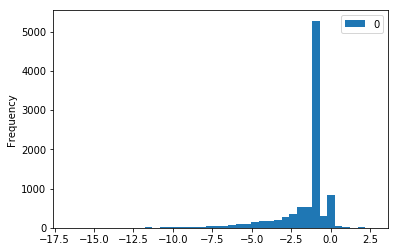

In [71]:
df.plot(bins=40, kind="hist")